In [4]:
import scipy
import numpy as np
from sympy.utilities.iterables import multiset_partitions
from itertools import permutations
# plot the bn values
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
import math
from tqdm import tqdm

In [ ]:
n_ = 150

f = {1: {0: 1}}
for n in range(2,n_):
    f[n] = {0: 0}

B = scipy.special.bernoulli(n)

print('n, j, m, p, f[m][p], f[n-m][j-1]')

for n in range(2, n_):
    for j in range(1, n):
        f[n][j] = 0
        for m in range(1, n-j+1):
            for p in range(m):
                try:
                    f[n][j] += 2/m*abs(B[p])/np.math.factorial(p) * f[m][p] * f[n-m][j-1]
                except:
                    raise Warning(f'n={n} too large')


bn = {}
for n in range(n_):
    bn[n] = 0
    for j in range(1,n):
        bn[n] += abs(B[j])/np.math.factorial(j) * f[n][j]

In [ ]:
#logscale
plt.yscale('log')


plt.plot(list(bn.keys()), list(bn.values()), label = '$b_n$')

# make a fit of the result to e^(-x)
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b * x**c)

xdata = list(bn.keys())
ydata = list(bn.values())
popt, pcov = curve_fit(func, xdata[40:], ydata[40:], p0 = [0.34817, 0.16905, 0.88245])

pred_data = []
for x in xdata:
    pred_data.append(func(x, *popt))

plt.plot(xdata, pred_data, 'r-', label='fit: $a\cdot e^{-b x^c}$,  a=%5.5f, b=%5.5f, c=%5.5f' % tuple(popt))

plt.xlabel('n')
plt.ylabel('$b_n$')

plt.legend()

plt.savefig('bn.pdf')

# Bounding the error of the product of exponentials

In [27]:
s = 2
p = 6
m = 3
def compositions(p,s):
    r"""
    p: integers up to which compositions add up
    s: maximum value of each term in the composition
    """
    if p == 1:
        return [[1]]
    else:
        comps = []
        for i in range(1, p):
            for comp in compositions(p-i, s):
                comps.append([i] + comp)
        comps.append([p])

    new_comps = []
    for c in comps:
        if max(np.array(c)) <= s:
            new_comps.append(c)

    return new_comps


comps = compositions(p,s)
comps

[[1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 2],
 [1, 1, 1, 2, 1],
 [1, 1, 2, 1, 1],
 [1, 1, 2, 2],
 [1, 2, 1, 1, 1],
 [1, 2, 1, 2],
 [1, 2, 2, 1],
 [2, 1, 1, 1, 1],
 [2, 1, 1, 2],
 [2, 1, 2, 1],
 [2, 2, 1, 1],
 [2, 2, 2]]

In [28]:
def weak_compositions(w, m):
    r"""
    w: sum of the composition
    m: number of bins

    We use the method of 1s and bars to generate all possible weak compositions
    of a given size.

    We first use itertools to generate all products of (1,...,w-1)^m.
    Then, for each element, we order the resulting list of bars, and compute the 
    corresponding weak composition.
    """
    from itertools import product

    # generate all products of (1,...,w-1)^m
    products = product(range(w+1), repeat=m-1)

    wcomps = []
    for prod in products:
        # sort the product
        prod = sorted(prod)

        # compute the weak composition
        comp = [prod[0]]
        for i in range(1, len(prod)):
            comp.append(prod[i]-prod[i-1])
        comp.append(w-prod[-1])

        if comp not in wcomps:
            wcomps.append(comp)

    return wcomps

wc = weak_compositions(3, 4)
wc

[[0, 0, 0, 3],
 [0, 0, 1, 2],
 [0, 0, 2, 1],
 [0, 0, 3, 0],
 [0, 1, 0, 2],
 [0, 1, 1, 1],
 [0, 1, 2, 0],
 [0, 2, 0, 1],
 [0, 2, 1, 0],
 [0, 3, 0, 0],
 [1, 0, 0, 2],
 [1, 0, 1, 1],
 [1, 0, 2, 0],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [1, 2, 0, 0],
 [2, 0, 0, 1],
 [2, 0, 1, 0],
 [2, 1, 0, 0],
 [3, 0, 0, 0]]

0it [00:00, ?it/s]/var/folders/gw/hkbhst095x91whnxk3s59p5m0000gq/T/ipykernel_20626/3072196438.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  suma += 1/np.prod([np.math.factorial(i) for i in w])
 78%|███████▊  | 7/9 [02:48<00:48, 24.03s/it]
6it [04:17, 42.93s/it]


KeyboardInterrupt: 

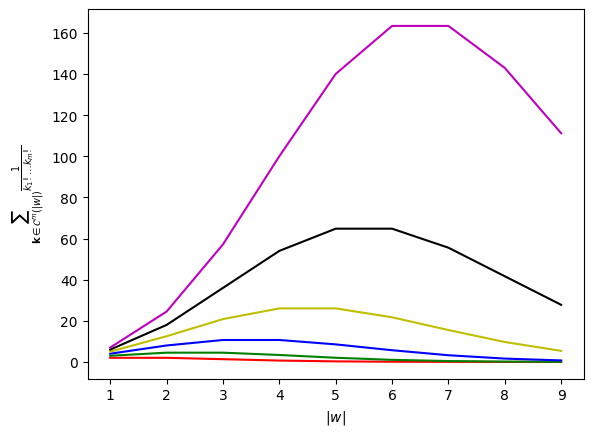

In [140]:
maximums = {}

plt.xlabel(r'$|w|$')
plt.ylabel(r'$\sum_{\mathbf{k} \in \mathcal{C}^{m} (|w|)}\frac{1}{k_1!\ldots k_m!}$')

for m, color in tqdm(zip(range(2, 9),['r', 'g', 'b', 'y', 'k', 'm', 'c', 'orange', 'purple', 'black'])):
    ps = range(1, 10)
    sumas = []
    upper_bounds = []
    for p in tqdm(ps):
        wc = weak_compositions(p, m)

        # Plot the product of the factorial of the elements in w for w in wc
        suma = 0
        upper_bound = 0
        for w in wc:
            suma += 1/np.prod([np.math.factorial(i) for i in w])
            upper_bound += 1/(math.factorial(int(p/m)))**m

        sumas.append(suma)
        upper_bounds.append(upper_bound)

    plt.plot(ps, sumas, color = color, label = f'm={m}')
    #plt.plot(ps, upper_bounds, '-', color = color, label = f'm={m}')
    maximums[m] = max(sumas)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')

for k, v in maximums.items():
    print(f'm={k}, max={v}')

plt.savefig('max_arg.pdf')

In [138]:
a = []
for i in range(2, 8):
    a.append(maximums[i+1]/maximums[i])

for i in range(1,len(a)):
    print(a[i]-a[i-1])

0.12037037037037024
0.0710358796296302
0.046913750000002086
0.03330637174211715
0.02487332529857067


In [6]:
comps_len = [len(c) for c in comps]

In [44]:
s = 3
m = 3

def add_term(len_c, m, c = 1):

    l = weak_compositions(len_c, m)

    sum = 0
    for wc in l:
        sum += c**(len_c) / np.prod([math.factorial(i) for i in wc])
    mean = sum / len(l)
    return sum, mean

vadd = np.vectorize(add_term)

part_sums, means = vadd(comps_len, m)
total_sums = np.sum(part_sums)
total_sums

16.050604275746572

In [ ]:
from matplotlib.ticker import MaxNLocator


s = 3
# create two subplots
fig, ax = plt.subplots(1, 2)

plt.suptitle('c = 1, s = %i' % s)

for m in tqdm(range(6, 3, -1), desc = 'm values'):
    ts = []
    ms = []
    ps = range(2*s, 12)
    for p in tqdm(ps, desc = 'pth order'):
        comps = compositions(p,s)

        comps_len = [len(c) for c in comps]

        partial_sums, means = vadd(comps_len, m)

        total_sum = np.sum(partial_sums)
        average_mean = np.mean(means)

        ts.append(total_sum)
        ms.append(average_mean)

    # plot
    ax[0].plot(ps, ts, label = 'm = %i' % m)
    ax[1].plot(ps, ms, label = 'm = %i' % m)

    ax[0].set_title(r'$\|\Psi_{m,p}^{[2s]}\|/h^p$')
    ax[1].set_title(r'Average $\frac{1}{k_1!\ldots k_m!}$')

    ax[0].set_xlabel('order p')
    ax[1].set_xlabel('order p')
    
    # set x ticks at integer values
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

#plt.yscale('log')

plt.legend()
plt.savefig(f'weak_compositions_s={s}.pdf')

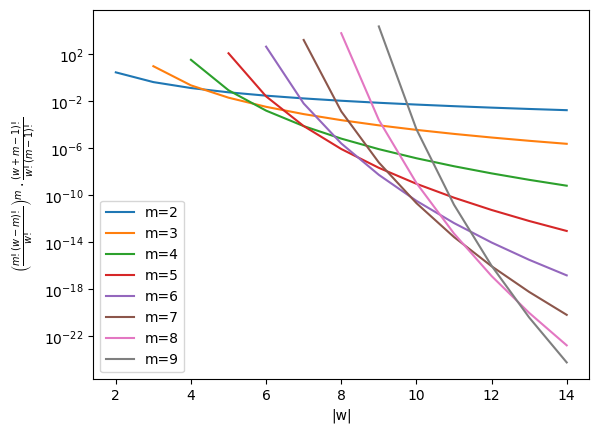

In [150]:
def factor(m, w):
    return ((math.factorial(m)*math.factorial(w-m)/math.factorial(w))**m * 
            math.factorial(w+m-1)/(math.factorial(w)*math.factorial(m-1)))

for m in range(2, 10):
    results = []
    wrange = range(m, 15)
    for w in wrange:
        results.append(factor(m, w))

    plt.plot(wrange, results, label = f'm={m}')

plt.yscale('log')

plt.xlabel('|w|')
plt.ylabel(r'$\left(\frac{m!(w-m)!}{w!}\right)^m \cdot \frac{(w+m-1)!}{w!(m-1)!}$')
plt.legend()

plt.savefig('factor.pdf')

m values: 100%|██████████| 3/3 [01:04<00:00, 21.50s/it]


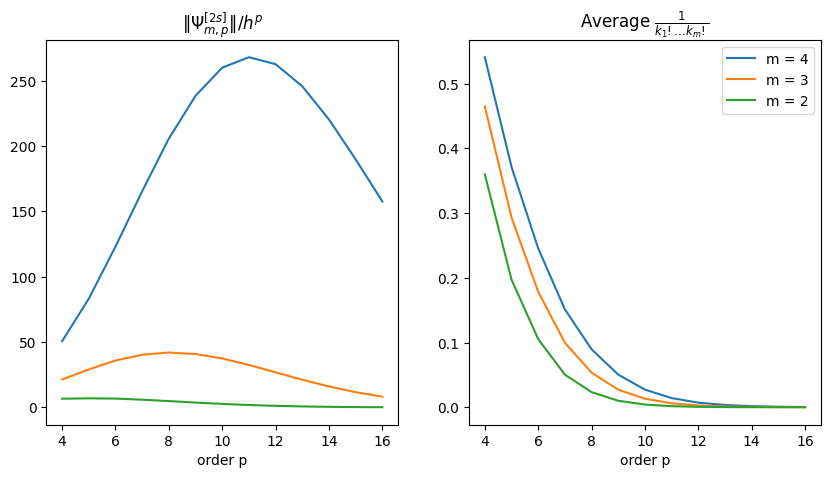

In [151]:
from matplotlib.ticker import MaxNLocator


s = 2
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#plt.suptitle('c = 1, s = %i' % s)

for m in tqdm(range(4, 1, -1), desc = 'm values'):
    ts = []
    ms = []
    ps = range(2*s, 17)
    for p in tqdm(ps, desc = 'pth order'):
        comps = compositions(p,s)

        comps_len = [len(c) for c in comps]

        partial_sums, means = vadd(comps_len, m)

        total_sum = np.sum(partial_sums)
        average_mean = np.mean(means)

        ts.append(total_sum)
        ms.append(average_mean)

    # plot
    ax[0].plot(ps, ts, label = 'm = %i' % m)
    ax[1].plot(ps, ms, label = 'm = %i' % m)

    ax[0].set_title(r'$\|\Psi_{m,p}^{[2s]}\|/h^p$')
    ax[1].set_title(r'Average $\frac{1}{k_1!\ldots k_m!}$')

    ax[0].set_xlabel('order p')
    ax[1].set_xlabel('order p')
    
    # set x ticks at integer values
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()

plt.savefig(f'weak_compositions_s={s}.pdf')

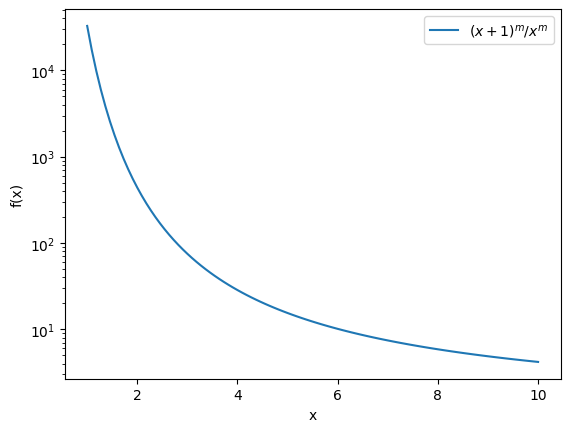

In [25]:
# Plot the function f(x) = (x+1)^m/x^m
x = np.linspace(1, 10, 100)
m = 15
plt.plot(x, (x+1)**m/x**m, label = '$(x+1)^m/x^m$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.yscale('log')
plt.legend()

### Alternative way of computing the norm of $\|\Psi^{[2s]}_{m,p}\|$

In [32]:
factorial = {}

for i in range(100):
    factorial[i] = np.longdouble(math.factorial(i))

for i in range(100):
    print(f'{i}! = {factorial[i]}')

0! = 1.0
1! = 1.0
2! = 2.0
3! = 6.0
4! = 24.0
5! = 120.0
6! = 720.0
7! = 5040.0
8! = 40320.0
9! = 362880.0
10! = 3628800.0
11! = 39916800.0
12! = 479001600.0
13! = 6227020800.0
14! = 87178291200.0
15! = 1307674368000.0
16! = 20922789888000.0
17! = 355687428096000.0
18! = 6402373705728000.0
19! = 1.21645100408832e+17
20! = 2.43290200817664e+18
21! = 5.109094217170944e+19
22! = 1.1240007277776077e+21
23! = 2.585201673888498e+22
24! = 6.204484017332394e+23
25! = 1.5511210043330986e+25
26! = 4.0329146112660565e+26
27! = 1.0888869450418352e+28
28! = 3.0488834461171387e+29
29! = 8.841761993739702e+30
30! = 2.6525285981219107e+32
31! = 8.222838654177922e+33
32! = 2.631308369336935e+35
33! = 8.683317618811886e+36
34! = 2.9523279903960416e+38
35! = 1.0333147966386145e+40
36! = 3.7199332678990125e+41
37! = 1.3763753091226346e+43
38! = 5.230226174666011e+44
39! = 2.0397882081197444e+46
40! = 8.159152832478977e+47
41! = 3.345252661316381e+49
42! = 1.40500611775288e+51
43! = 6.041526306337383e+52
4

In [101]:
from sympy.utilities.iterables import partitions
def efficient_number_compositions(p, s):
    r"""
    p: integers up to which compositions add up
    s: maximum value of each term in the composition

    Computes a dictionary where the key is the length of the composition,
    and the value is the number of compositions of that length.
    """
    pts = partitions(p, k=s)
    
    comps = {}
    for part in pts:
        len_ = np.sum(list(part.values()))

        num_comps = factorial[len_]
        for n in part.values():
            num_comps /= factorial[n]

        if len_ in comps.keys():
            comps[len_] += num_comps
        else:
            comps[len_] = num_comps

    return comps


s = 4
for p in range(50):
    d = efficient_number_compositions(p, s)
    print(f'{p}, {np.sum(list(d.values()))/2**p}')

0, 1.0
1, 0.5
2, 0.5
3, 0.5
4, 0.5
5, 0.46875
6, 0.453125
7, 0.4375
8, 0.421875
9, 0.40625
10, 0.3916015625
11, 0.37744140625
12, 0.36376953125
13, 0.3505859375
14, 0.337890625
15, 0.325653076171875
16, 0.3138580322265625
17, 0.302490234375
18, 0.291534423828125
19, 0.280975341796875
20, 0.2707986831665039
21, 0.26099061965942383
22, 0.2515377998352051
23, 0.24242734909057617
24, 0.23364686965942383
25, 0.22518441081047058
26, 0.2170284539461136
27, 0.20916789770126343
28, 0.20159204304218292
29, 0.19429057836532593
30, 0.18725356552749872
31, 0.18047142634168267
32, 0.1739349295385182
33, 0.16763517819344997
34, 0.16156359761953354
35, 0.1557119236967992
36, 0.15007219162362162
37, 0.14463672507554293
38, 0.13939812575699762
39, 0.1343492633313872
40, 0.12948326571586222
41, 0.12479350972762404
42, 0.12027361206901332
43, 0.11591742063910715
44, 0.1117190061600013
45, 0.1076726541063806
46, 0.10377285692739235
47, 0.10001430655023569
48, 0.09639188715526359
49, 0.09290066821276355


In [2]:
from sympy.utilities.iterables import partitions
for p in partitions(6, m=3):  
    print(p)

{6: 1}
{5: 1, 1: 1}
{4: 1, 2: 1}
{4: 1, 1: 2}
{3: 2}
{3: 1, 2: 1, 1: 1}
{2: 3}


In [102]:
def efficient_weak_compositions(maxw, rangem):
    r"""
    Computes sum{k_1...k_m\in weak_compositions} 1/(k_1!...k_m!) for all weak compositions of length m.

    maxw: maximum value of the sum of the weak composition
    rangem: range of m values
    """

    weak_comps = {}
    for m in rangem:
        weak_comps[m] = {}
        for normw in range(maxw+1):
            
            suma = np.longdouble(0)

            pts = partitions(normw, m=m)

            for part in pts:
                len_ = np.sum(list(part.values()))

                num_comps = factorial[m]/factorial[m-len_]
                for n in part.values():
                    num_comps /= factorial[n]

                denominator = np.longdouble(1)
                for i in part.keys():
                    denominator = denominator*factorial[i]

                suma = suma + num_comps/denominator

            weak_comps[m][normw] = suma

    return weak_comps

rangem = [5, 6, 11]
maxw = 50
weak_comps = efficient_weak_compositions(maxw, rangem)
for m in [11]:
    for normw in range(maxw+1):
        #print(f'm={m}, w={normw}, result={weak_comps[m][normw]}')
        continue

In [ ]:
for m in [11]:
    for normw in range(maxw+1):
        print(f'm={m}, w={normw}, result={weak_comps[m][normw]}')

In [123]:
s = 2
maxp = 50
m = 11
h = 1

if m == 5:
    c = 0.34815492558797391479
elif m == 6:
    c = 0.312
elif m == 11:
    c = 0.571855043580130805495594


h = 1/(4*m)
def summatory_compositions(maxp, s):

    weak_comps = efficient_weak_compositions(maxp, [m])
    
    suma = {}
    for p in range(1, maxp+1):
        num_comps = efficient_number_compositions(p, s)

        suma[p] = np.longdouble(0)
        for len_comp, nc in num_comps.items():
            suma[p] += nc*weak_comps[m][len_comp] * (np.max([c,1]))**len_comp * h**p

    return suma


sum_compositions = summatory_compositions(maxp, s)

#accumulate sum_compositions
acc_sum_compositions = {}
acc_sum_compositions[0] = 0
for i in range(1, maxp+1):
    acc_sum_compositions[i] = acc_sum_compositions[i-1] + sum_compositions[i]


for i in range(1, maxp+1):
    print(f'{i}: {sum_compositions[i]}, {acc_sum_compositions[i]}')

1: 0.25, 0.25
2: 0.036931818181818184, 0.2869318181818182
3: 0.004024621212121212, 0.2909564393939394
4: 0.000360127293075382, 0.2913165666870148
5: 2.8053688237085358e-05, 0.2913446203752519
6: 1.973289362698212e-06, 0.2913465936646146
7: 1.2813152353303814e-07, 0.29134672179613813
8: 7.780778810576825e-09, 0.29134672957691693
9: 4.4519495504184437e-10, 0.29134673002211187
10: 2.411894539128802e-11, 0.2913467300462308
11: 1.242293368660945e-12, 0.2913467300474731
12: 6.10947519682355e-14, 0.2913467300475342
13: 2.882342680584518e-15, 0.2913467300475371
14: 1.311033326083355e-16, 0.2913467300475372
15: 5.777500440434253e-18, 0.2913467300475372
16: 2.4778634548092753e-19, 0.2913467300475372
17: 1.0381946860833981e-20, 0.2913467300475372
18: 4.261911888830083e-22, 0.2913467300475372
19: 1.7174235722296614e-23, 0.2913467300475372
20: 6.800085652146521e-25, 0.2913467300475372
21: 2.64624971106309e-26, 0.2913467300475372
22: 1.0120041223841467e-27, 0.2913467300475372
23: 3.8027262340309277e

In [124]:
def acc_from(i, sum_compositions):
    
    acc_sum_compositions = {}
    acc_sum_compositions[i-1] = 0
    for i in range(i, maxp+1):
        acc_sum_compositions[i] = acc_sum_compositions[i-1] + sum_compositions[i]

    return acc_sum_compositions

acc_sum_compositions = acc_from(2*s+1, sum_compositions)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

5: 2.8053688237085358e-05
6: 3.002697759978357e-05
7: 3.0155109123316606e-05
8: 3.0162889902127184e-05
9: 3.0163335097082226e-05
10: 3.0163359216027616e-05
11: 3.0163360458320983e-05
12: 3.0163360519415735e-05
13: 3.0163360522298076e-05
14: 3.016336052242918e-05
15: 3.0163360522434957e-05
16: 3.0163360522435204e-05
17: 3.0163360522435214e-05
18: 3.0163360522435214e-05
19: 3.0163360522435214e-05
20: 3.0163360522435214e-05
21: 3.0163360522435214e-05
22: 3.0163360522435214e-05
23: 3.0163360522435214e-05
24: 3.0163360522435214e-05
25: 3.0163360522435214e-05
26: 3.0163360522435214e-05
27: 3.0163360522435214e-05
28: 3.0163360522435214e-05
29: 3.0163360522435214e-05
30: 3.0163360522435214e-05
31: 3.0163360522435214e-05
32: 3.0163360522435214e-05
33: 3.0163360522435214e-05
34: 3.0163360522435214e-05
35: 3.0163360522435214e-05
36: 3.0163360522435214e-05
37: 3.0163360522435214e-05
38: 3.0163360522435214e-05
39: 3.0163360522435214e-05
40: 3.0163360522435214e-05
41: 3.0163360522435214e-05
42: 3.01

In [125]:
(2*m*h*np.max([1,c]))**(2*s+1)/(1-2*m*h*np.max([1,c]))

0.0625

In [23]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Gaussian function
def gaussian(x, mean, std, mult):
    return mult/(std*np.sqrt(2*np.pi)) * np.exp(-((x-mean)**2) / (2*std**2))

# Fit the Gaussian distribution to the data
mean_init = 25
std_init = 10
params, params_cov = curve_fit(gaussian, list(sum_compositions.keys()), list(sum_compositions.values()), p0=[mean_init, std_init, 10000])
mean_fit = params[0]
std_fit = params[1]
mult_fit = params[2]

# Plot the fitted curve on top of the histogram
x = np.linspace(0, 50, 1000)
plt.plot(x, gaussian(x, mean_fit, std_fit, mult_fit), color='red', label='fit: mean=%5.3f, std=%5.3f, mult=%5.3f' % (mean_fit, std_fit, mult_fit))
plt.plot(list(sum_compositions.keys()), list(sum_compositions.values()), color = 'blue', label = 'data')

plt.xlabel('p')

plt.legend()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

## Average size of the compositions

pth order: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


ratio converges to 0.5003663711770674


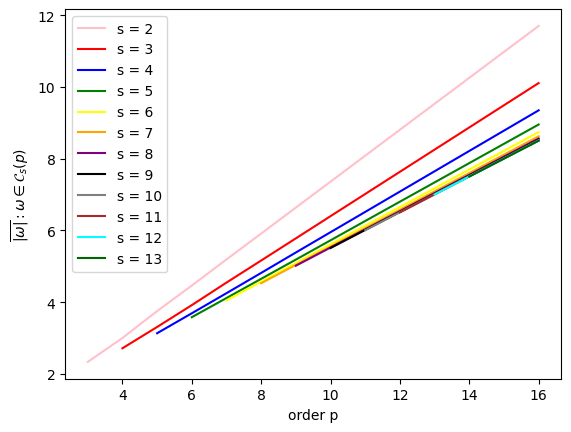

In [124]:
for s, color in zip(range(2, 15), ['pink', 'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'black', 'grey', 'brown', 'cyan', 'darkgreen']):
    ps = range(s+1, 17)
    averages = []
    for p in tqdm(ps, desc = 'pth order'):
        comps = compositions(p,s)

        # Compute average length of compositions
        lengths = []
        means = []
        for c in comps:
            lengths.append(len(c))
            means.append(np.mean(c))
        avg_length = np.mean(lengths)
        avg_mean = np.mean(means)
        averages.append(avg_length)

        # Plot the average length against p
    plt.plot(ps, averages, '-', color = color, label = f's = {s}')
    #plt.plot(p, avg_mean, 'o', color = color, label = f'composition mean for s = {s}')

plt.xlabel('order p')
plt.ylabel(r'$\overline{|\omega|}: \omega\in \mathcal{C}_{s}(p)$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

print('ratio converges to', averages[-1]-averages[-2])

plt.savefig('average_length.pdf')

# n-Fibonacci numbers

In [31]:
# Generate the s-th fibonacci sequence, starting with s-1 0s and a 1

def fib(s, n):
    r"""
    s: The order generalization of the fibonacci sequence
    n: number of fibonacci numbers to generate
    """
    f = [0]*(s-1) + [1]
    for i in range(n-1):
        f.append(np.sum(f[-s:]))

    return f

f = fib(3, 10)
print(f)

[0, 0, 1, 1, 2, 4, 7, 13, 24, 44, 81, 149]


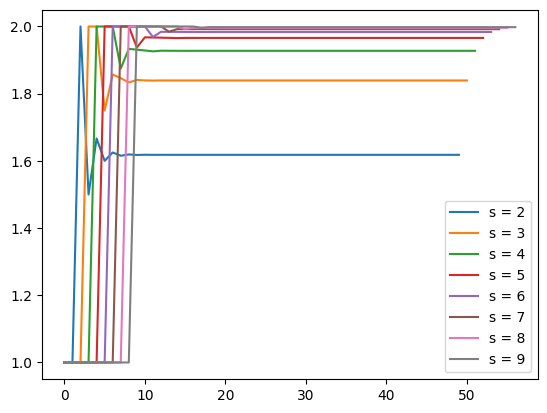

In [45]:
# Generate the s-th fibonacci sequences for s in range(2, 10), and plot the ratio between consecutive terms

for s in range(2, 10):
    f = fib(s, 50)
    ratios = [1]*(s-1) + [f[i+1]/f[i] for i in range(s-1,len(f)-1)]
    plt.plot(range(len(ratios)), ratios, label = 's = %i' % s)

plt.legend()

In [43]:
s = 9
f = fib(8, 100)
ratios = [1]*(s-1) + [f[i+1]/f[i] for i in range(s-1,len(f)-1)]
for i in range(len(ratios)):
    print(i, ratios[i])

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 2.0
9 2.0
10 2.0
11 2.0
12 2.0
13 2.0
14 2.0
15 1.9921875
16 1.996078431372549
17 1.9960707269155207
18 1.9960629921259843
19 1.9960552268244576
20 1.9960474308300395
21 1.996039603960396
22 1.996031746031746
23 1.9960238568588469
24 1.996031499003984
25 1.9960314056932564
26 1.9960313275131345
27 1.9960312645549654
28 1.996031216910467
29 1.9960311846717278
30 1.9960311679312068
31 1.9960311667817339
32 1.9960311813165093
33 1.9960311806848339
34 1.996031180237437
35 1.9960311799446007
36 1.9960311797763652
37 1.9960311797025294
38 1.9960311796926489
39 1.9960311797160348
40 1.9960311797417527
41 1.9960311797386217
42 1.9960311797367403
43 1.9960311797357446
44 1.9960311797353294
45 1.9960311797352477
46 1.9960311797353127
47 1.9960311797353976
48 1.9960311797354362
49 1.9960311797354235
50 1.996031179735417
51 1.9960311797354147
52 1.996031179735414
53 1.996031179735414
54 1.9960311797354144
55 1.9960311797354147
56 1.9960311797354147
57 1.9960311797

# Quadrature error

n values: 100%|██████████| 7/7 [00:00<00:00, 209.34it/s]


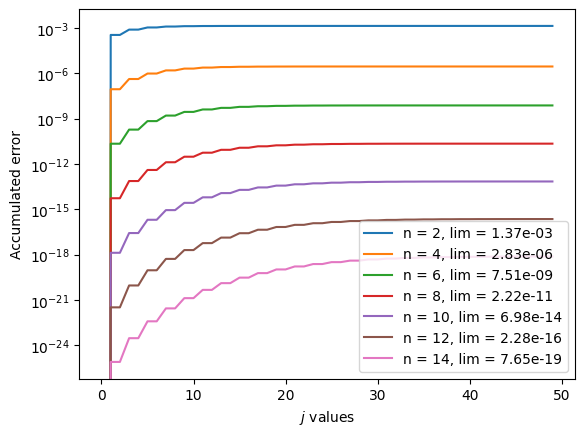

In [16]:
maximums = {}
for n in tqdm(range(2, 15, 2), desc = 'n values'):
    partial_sums = []
    for j in range(0, 350):
        term = math.factorial(2*n+j)/math.factorial(j)*(1-(-1)**j)/((j+2*n)*2**(2*n+j))
        partial_sums.append(term + partial_sums[-1] if len(partial_sums) > 0 else term)

    partial_sums = np.array(partial_sums)
    partial_sums *= (math.factorial(n)/math.factorial(2*n))**3 * math.factorial(n)/(2*n+1)

    maximums[n] = partial_sums[-1]
    plt.plot(range(0, 50), partial_sums[:50], label = f'n = {n}, lim = {maximums[n]:.2e}')

plt.yscale('log')

plt.xlabel(r'$j$ values')
plt.ylabel('Accumulated error')

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

#plt.yticks(list(maximums.values()))

plt.savefig('accumulated_error.pdf')

In [8]:
len(maximums), 

(13,)

i values: 100%|██████████| 8/8 [00:00<00:00, 42.76it/s]


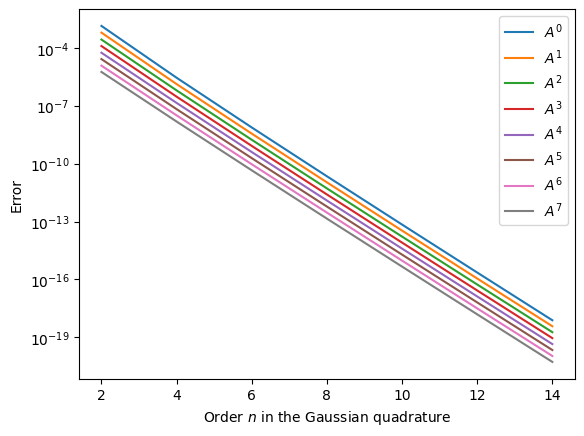

In [24]:
maximums = {}
for i in tqdm(range(0, 8, 1), desc = 'i values'):
    maximums[i] = {}
    for n in tqdm(range(2, 15, 2), desc = 'n values'):
        partial_sums = []
        for j in range(0, 350):
            term = math.factorial(2*n+j)/math.factorial(j)*(1-(-1)**(i+j))/((i+j+2*n)*2**(2*n+j+i))
            partial_sums.append(term + partial_sums[-1] if len(partial_sums) > 0 else term)

        partial_sums = np.array(partial_sums)
        partial_sums *= (math.factorial(n)/math.factorial(2*n))**3 * math.factorial(n)/(2*n+1)

        maximums[i][n] = partial_sums[-1]

plt.yscale('log')

# Plot the accumulated error for different values of n and i
for i in range(0, 8, 1):
    plt.plot(range(2, 15, 2), [maximums[i][n] for n in range(2, 15, 2)], label = f'$A^{( i )}$')

plt.xlabel(r'Order $n$ in the Gaussian quadrature')
plt.ylabel('Error')

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

#plt.yticks(list(maximums.values()))

plt.savefig('Error_of_A^(i).pdf')

# Trash

In [ ]:
def distribute(c, m):
    r"""
    c: Composition to be distributed
    m: Number of bins
    """
    c += [0]*(m-1)
    clean_permutations = []
    msp = list(multiset_partitions(c, m))
    for p in msp:
        for l in range(len(p)):
            while 0 in p[l]:
                p[l].remove(0)
        b = list(permutations(p))
        for item in b:
            if item not in clean_permutations:
                clean_permutations.append(item)

    return clean_permutations

In [7]:
l = []
for c in comps:
    l = l + distribute(c, m)

sum = 0
for wc in l:
    sum += 1 / np.prod([np.math.factorial(i) for i in wc])
print(sum)

NameError: name 'distribute' is not defined

In [ ]:
a = list(multiset_partitions([1,1,2,1,1], 3))
b = list(permutations(a[0]))
print(a[0])
print(b)
